# Get data from QLVTHC

In this notebook we gather the segmentations produced by the tool QLVTHC (both using DICOM and JPG images) and compare the obtained PTA with the PTA reported in the excel files in order to detect if great differences exist.

In [1]:
import os
import re
import pandas as pd
import numpy as np
from shutil import copy

In [2]:
experiments = [
     {
         "name": "initial_dcm",
         "folder": "../../lvnc-dataset/OUTPUT_FROM_DCM/"
     },
     {
         "name": "initial_jpg",
         "folder": "../../lvnc-dataset/OUTPUT/"
     },
     {
         "name": "29_CV3_jpg",
         "folder": "../../lvnc-dataset/OUTPUT_JPG_29_CV3/"
     },
     {
         "name": "29_CV3_dcm",
         "folder": "../../lvnc-dataset/OUTPUT_DCM_29_CV3/"
     },
     {
         "name": "072_jpg",
         "folder": "../../lvnc-dataset/OUTPUT_JPG_072/"
     },
     {
         "name": "072_dcm",
         "folder": "../../lvnc-dataset/OUTPUT_DCM_072/"
     },
    {
        "name": "072_jpg_todocv3",
        "folder": "../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTHON/"
    },
    {
        "name": "072_dcm_todocv3",
        "folder": "../../lvnc-dataset/OUTPUT_DCM_072_TODOCV3_PYTHON/"
    },
    {
        "name": "29_jpg_todocv3",
        "folder": "../../lvnc-dataset/OUTPUT_JPG_29_TODOCV3_PYTHON/"
    },
    {
        "name": "29_dcm_todocv3",
        "folder": "../../lvnc-dataset/OUTPUT_DCM_29_TODOCV3_PYTHON/"
    }
]

In [3]:
regex_filename = r'(?P<patient>\w+)_(?P<slice>\w+)_results.txt'

def process_file(filename, folder):
    match = re.search(regex_filename, filename)
    if match:
        patient = match.group('patient')
        slice_num = match.group('slice')
        
        # Get PTA value
        filepath = os.path.join(folder, filename)
        pta_parsed = [re.findall(r'Porcentaje trabecular final: ([+-]?[0-9]*[.]?[0-9]+) ?%?',line) for i, line in enumerate(open(filepath)) if i==6]
        
        if pta_parsed:
            try:
                pta_parsed = pta_parsed[0][0]
            except:
                pta_parsed = None
        
        return {'patient': patient,
                'slice': int(slice_num),
                'pta': float(pta_parsed) if pta_parsed else None,
                'output_jpg': filepath.replace("_results.txt", "_output.jpg")
                }
    else:
        return None

In [4]:
all_rows = []

for experiment in experiments:
    name, folder = experiment["name"], experiment["folder"]
    rows = [row for row in map(lambda x: process_file(x, folder), os.listdir(folder)) if row is not None]
    for row in rows:
        row["experiment"] = name
    all_rows.extend(rows)
    
df = pd.DataFrame(all_rows)

In [5]:
df

,patient,slice,pta,output_jpg,experiment
0,P40,1,5.14,../../lvnc-dataset/OUTPUT_FROM_DCM/P40_1_outpu...,initial_dcm
1,P175,8,36.36,../../lvnc-dataset/OUTPUT_FROM_DCM/P175_8_outp...,initial_dcm
2,P227,6,19.49,../../lvnc-dataset/OUTPUT_FROM_DCM/P227_6_outp...,initial_dcm
3,P71,3,38.65,../../lvnc-dataset/OUTPUT_FROM_DCM/P71_3_outpu...,initial_dcm
4,X9,2,29.84,../../lvnc-dataset/OUTPUT_FROM_DCM/X9_2_output...,initial_dcm
...,...,...,...,...,...
29400,X60,5,38.29,../../lvnc-dataset/OUTPUT_DCM_29_TODOCV3_PYTHO...,29_dcm_todocv3
29401,P72,5,22.33,../../lvnc-dataset/OUTPUT_DCM_29_TODOCV3_PYTHO...,29_dcm_todocv3
29402,P155,5,36.57,../../lvnc-dataset/OUTPUT_DCM_29_TODOCV3_PYTHO...,29_dcm_todocv3
29403,P176,8,28.52,../../lvnc-dataset/OUTPUT_DCM_29_TODOCV3_PYTHO...,29_dcm_todocv3


Now we read the df with the information of the excel files in order to perform the comparison

In [6]:
df_excel = pd.read_pickle("../../lvnc-dataset/original-data/df_excel.pick").reset_index()

Replace the PTA obtained from the excel files with the PTA present in the original Results.txt files.

In [7]:
n_rows = []
for i, row in df_excel.iterrows():
    dcm_path = row["dicom_path"]
    results_path = dcm_path.replace(".dcm", "Result.txt")
    assert os.path.isfile(results_path)
    pta_parsed = [re.findall(r'Porcentaje trabecular final: ([+-]?[0-9]*[.]?[0-9]+) ?%?',line) for i, line in enumerate(open(results_path)) if i==6]
    try:
        pta_parsed[0][0]
        row["pta"] = float(pta_parsed[0][0])
    except:
        print(results_path)
    n_rows.append(row)

df_excel = pd.DataFrame(n_rows)

/root/lvnc-dataset/original-data/HCM/P257/P257I1Result.txt
/root/lvnc-dataset/original-data/HCM/P257/P257I2Result.txt
/root/lvnc-dataset/original-data/HCM/P257/P257I3Result.txt
/root/lvnc-dataset/original-data/HCM/P257/P257I4Result.txt
/root/lvnc-dataset/original-data/HCM/P257/P257I5Result.txt
/root/lvnc-dataset/original-data/HCM/P257/P257I6Result.txt
/root/lvnc-dataset/original-data/HCM/P257/P257I7Result.txt
/root/lvnc-dataset/original-data/HCM/P257/P257I8Result.txt
/root/lvnc-dataset/original-data/HCM/P257/P257I9Result.txt
/root/lvnc-dataset/original-data/HCM/P257/P257I10Result.txt
/root/lvnc-dataset/original-data/HCM/P258/P258I1Result.txt
/root/lvnc-dataset/original-data/HCM/P258/P258I2Result.txt
/root/lvnc-dataset/original-data/HCM/P258/P258I3Result.txt
/root/lvnc-dataset/original-data/HCM/P258/P258I4Result.txt
/root/lvnc-dataset/original-data/HCM/P258/P258I5Result.txt
/root/lvnc-dataset/original-data/HCM/P258/P258I6Result.txt
/root/lvnc-dataset/original-data/HCM/P258/P258I7Result.

In [8]:
df_excel['pta'] = df_excel['pta'].apply(lambda x: x.replace(",", ".").replace("%", "") if isinstance(x, str) else x)
df_excel['pta'] = df_excel['pta'].astype(float)

In [9]:
df_final = pd.merge(df, df_excel, on=['patient','slice'], how='outer', indicator="_merge", suffixes=("_computed", "_original"))
df_final["diff_pta"] = abs(df_final["pta_original"] - df_final["pta_computed"])

Discard patients 140 and 141 due to problem with files. We also discard Cac-9 and FDC-9 due to bad quality of the segmentations produced.

In [10]:
df_final = df_final[df_final["patient"]!="P140"]
df_final = df_final[df_final["patient"]!="P141"]
df_final = df_final[(df_final["patient"]!="CAC") | (df_final["slice"]!=9)]
df_final = df_final[(df_final["patient"]!="FDC") | (df_final["slice"]!=9)]

In [11]:
df_final

,patient,slice,pta_computed,output_jpg,experiment,score,reversed,pta_original,dicom_path,set,_merge,diff_pta
0,P40,1,5.14,../../lvnc-dataset/OUTPUT_FROM_DCM/P40_1_outpu...,initial_dcm,5.0,False,5.39,/root/lvnc-dataset/original-data/HCM/P40/P40I1...,HCM,both,0.25
1,P40,1,5.14,../../lvnc-dataset/OUTPUT/P40_1_output.jpg,initial_jpg,5.0,False,5.39,/root/lvnc-dataset/original-data/HCM/P40/P40I1...,HCM,both,0.25
2,P40,1,5.34,../../lvnc-dataset/OUTPUT_JPG_29_CV3/P40_1_out...,29_CV3_jpg,5.0,False,5.39,/root/lvnc-dataset/original-data/HCM/P40/P40I1...,HCM,both,0.05
3,P40,1,5.34,../../lvnc-dataset/OUTPUT_DCM_29_CV3/P40_1_out...,29_CV3_dcm,5.0,False,5.39,/root/lvnc-dataset/original-data/HCM/P40/P40I1...,HCM,both,0.05
4,P40,1,5.35,../../lvnc-dataset/OUTPUT_JPG_072/P40_1_output...,072_jpg,5.0,False,5.39,/root/lvnc-dataset/original-data/HCM/P40/P40I1...,HCM,both,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
29409,BPM,7,25.23,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...,072_jpg_todocv3,5.0,False,24.80,/root/lvnc-dataset/original-data/Hebron/BPM/im...,Hebron,both,0.43
29410,OPC,6,32.41,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...,072_jpg_todocv3,5.0,False,32.41,/root/lvnc-dataset/original-data/Hebron/OPC/im...,Hebron,both,0.00
29412,VPM,6,25.42,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...,072_jpg_todocv3,5.0,False,26.18,/root/lvnc-dataset/original-data/Hebron/VPM/im...,Hebron,both,0.76
29413,MHSML,7,51.79,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...,072_jpg_todocv3,4.5,False,51.61,/root/lvnc-dataset/original-data/Hebron/MHSML/...,Hebron,both,0.18


In [12]:
rows = []

for name, group in df_final.groupby(["patient", "slice"]):
    min_diff = np.nanmin(group["diff_pta"])
    best_id = group["diff_pta"].idxmin(axis=0)
    dcm_path = group.iloc[0]["dicom_path"]
    row = {
        "patient": name[0],
        "slice": name[1],
        "reversed": group.loc[best_id, "reversed"] if not np.isnan(best_id) else None,
        "set": group.loc[best_id, "set"] if not np.isnan(best_id) else None,
        "score": group.loc[best_id, "score"] if not np.isnan(best_id) else None,
        "pta_original": np.mean(group["pta_original"]),
        "pta_best_approach": group.loc[best_id, "pta_computed"] if not np.isnan(best_id) else None,
        "min_diff": min_diff,
        "best_approach": group.loc[best_id, "experiment"] if not np.isnan(best_id) else None,
        "original_output": dcm_path.replace(".dcm", "Sal.jpg"),
        "best_output": group.loc[best_id, "output_jpg"] if not np.isnan(best_id) else None
    }
    rows.append(row)

df_summary = pd.DataFrame(rows)

In [13]:
df_summary

,patient,slice,reversed,set,score,pta_original,pta_best_approach,min_diff,best_approach,original_output,best_output
0,ANH,4,False,Hebron,5.0,40.57,41.98,1.41,072_jpg_todocv3,/root/lvnc-dataset/original-data/Hebron/ANH/im...,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...
1,ANH,5,False,Hebron,5.0,42.02,42.02,0.00,072_jpg_todocv3,/root/lvnc-dataset/original-data/Hebron/ANH/im...,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...
2,ANH,6,False,Hebron,4.5,42.91,42.78,0.13,072_jpg_todocv3,/root/lvnc-dataset/original-data/Hebron/ANH/im...,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...
3,ANH,7,False,Hebron,4.5,38.70,38.60,0.10,072_jpg_todocv3,/root/lvnc-dataset/original-data/Hebron/ANH/im...,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...
4,ANH,8,False,Hebron,5.0,37.96,37.26,0.70,072_jpg_todocv3,/root/lvnc-dataset/original-data/Hebron/ANH/im...,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...
...,...,...,...,...,...,...,...,...,...,...,...
3077,X9,4,False,X,5.0,35.32,35.32,0.00,29_CV3_jpg,/root/lvnc-dataset/original-data/X/X9/X09I4Sal...,../../lvnc-dataset/OUTPUT_JPG_29_CV3/X9_4_outp...
3078,X9,5,False,X,5.0,30.86,30.86,0.00,29_CV3_jpg,/root/lvnc-dataset/original-data/X/X9/X09I5Sal...,../../lvnc-dataset/OUTPUT_JPG_29_CV3/X9_5_outp...
3079,X9,6,False,X,5.0,26.88,26.88,0.00,29_CV3_jpg,/root/lvnc-dataset/original-data/X/X9/X09I6Sal...,../../lvnc-dataset/OUTPUT_JPG_29_CV3/X9_6_outp...
3080,X9,7,False,X,5.0,25.68,25.68,0.00,initial_dcm,/root/lvnc-dataset/original-data/X/X9/X09I7Sal...,../../lvnc-dataset/OUTPUT_FROM_DCM/X9_7_output...


In [14]:
df_summary[pd.isnull(df_summary["min_diff"])]

,patient,slice,reversed,set,score,pta_original,pta_best_approach,min_diff,best_approach,original_output,best_output


In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_summary[pd.isnull(df_summary["min_diff"])][["patient", "slice"]])

Empty DataFrame
Columns: [patient, slice]
Index: []


In [16]:
len(df_summary[df_summary["min_diff"]>=5])

11

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_summary[df_summary["min_diff"]>=1][["patient", "slice", "min_diff", "best_approach"]].sort_values(by=["patient", "slice"]))

     patient  slice  min_diff    best_approach
0        ANH      4      1.41  072_jpg_todocv3
5        ANH      9      1.05  072_jpg_todocv3
6        BPM      2      7.04  072_jpg_todocv3
7        BPM      3      7.70  072_jpg_todocv3
9        BPM      5      5.75  072_jpg_todocv3
16       CAC      6      1.16      initial_dcm
21       CAC     12      1.18       29_CV3_jpg
32       CHG      4      2.26       29_CV3_jpg
34       CHG      6      2.20      initial_dcm
37       CHG      9      1.17       29_CV3_jpg
38       CHG     10      2.19          072_jpg
49      FAAJ      3      1.68      initial_dcm
50      FAAJ      4      1.80      initial_dcm
51      FAAJ      5      1.62       29_CV3_jpg
53      FAAJ      7      4.48       29_CV3_jpg
54      FAAJ      8      1.89       29_CV3_jpg
66       FGD      4      3.01  072_jpg_todocv3
69       FGD      7      1.70  072_jpg_todocv3
70       FGD      8      2.07  072_jpg_todocv3
71       FGD      9      1.21  072_jpg_todocv3
85       GDD 

In [18]:
len(df_summary[df_summary["min_diff"]>=1])

71

In [19]:
len(df_summary[df_summary["min_diff"]>=0.5])

107

In [20]:
df_summary.sort_values(by="min_diff", ascending=False).head(20)

,patient,slice,reversed,set,score,pta_original,pta_best_approach,min_diff,best_approach,original_output,best_output
1019,P195,10,False,HCM,5.0,18.53,8.93,9.60,initial_dcm,/root/lvnc-dataset/original-data/HCM/P195/P195...,../../lvnc-dataset/OUTPUT_FROM_DCM/P195_10_out...
790,P171,13,False,HCM,4.5,15.04,6.65,8.39,initial_dcm,/root/lvnc-dataset/original-data/HCM/P171/P171...,../../lvnc-dataset/OUTPUT_FROM_DCM/P171_13_out...
1168,P210,10,False,HCM,5.0,15.06,6.73,8.33,initial_dcm,/root/lvnc-dataset/original-data/HCM/P210/P210...,../../lvnc-dataset/OUTPUT_FROM_DCM/P210_10_out...
1045,P199,1,True,HCM,5.0,8.20,0.00,8.20,initial_dcm,/root/lvnc-dataset/original-data/HCM/P199/P199...,../../lvnc-dataset/OUTPUT_FROM_DCM/P199_1_outp...
7,BPM,3,False,Hebron,5.0,24.10,31.80,7.70,072_jpg_todocv3,/root/lvnc-dataset/original-data/Hebron/BPM/im...,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...
1122,P206,10,False,HCM,4.5,9.85,2.74,7.11,initial_dcm,/root/lvnc-dataset/original-data/HCM/P206/P206...,../../lvnc-dataset/OUTPUT_FROM_DCM/P206_10_out...
749,P168,11,False,HCM,5.0,22.51,15.46,7.05,initial_jpg,/root/lvnc-dataset/original-data/HCM/P168/P168...,../../lvnc-dataset/OUTPUT/P168_11_output.jpg
6,BPM,2,False,Hebron,5.0,29.97,22.93,7.04,072_jpg_todocv3,/root/lvnc-dataset/original-data/Hebron/BPM/im...,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...
1504,P247,1,True,HCM,5.0,6.82,1.03,5.79,initial_dcm,/root/lvnc-dataset/original-data/HCM/P247/P247...,../../lvnc-dataset/OUTPUT_FROM_DCM/P247_1_outp...
9,BPM,5,False,Hebron,5.0,41.41,35.66,5.75,072_jpg_todocv3,/root/lvnc-dataset/original-data/Hebron/BPM/im...,../../lvnc-dataset/OUTPUT_JPG_072_TODOCV3_PYTH...


Those with PTA difference below 1 are considered to be valid

## Visual comparison

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

P155 4


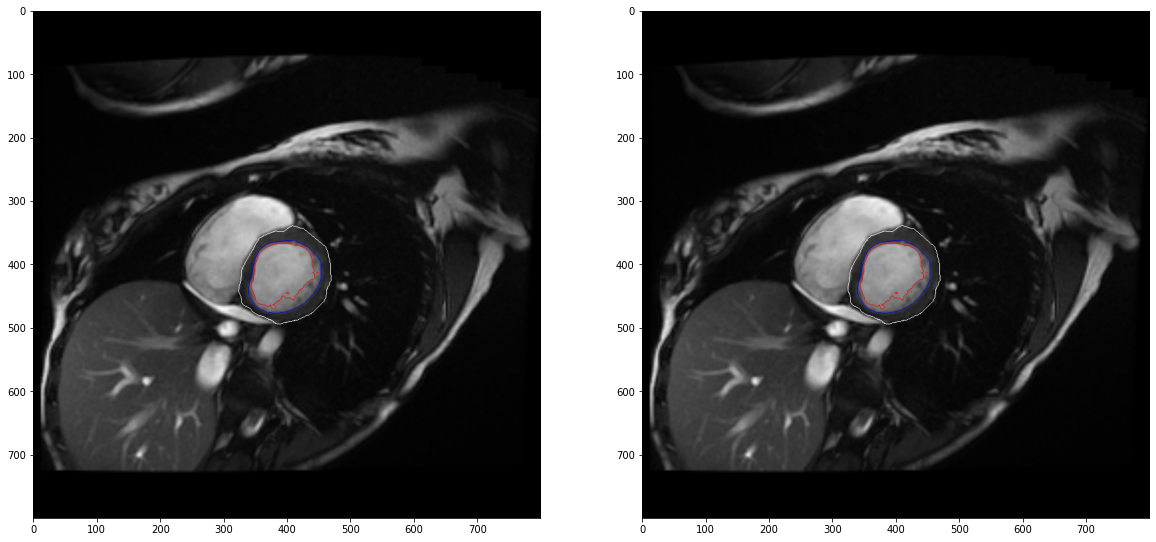

P136 4


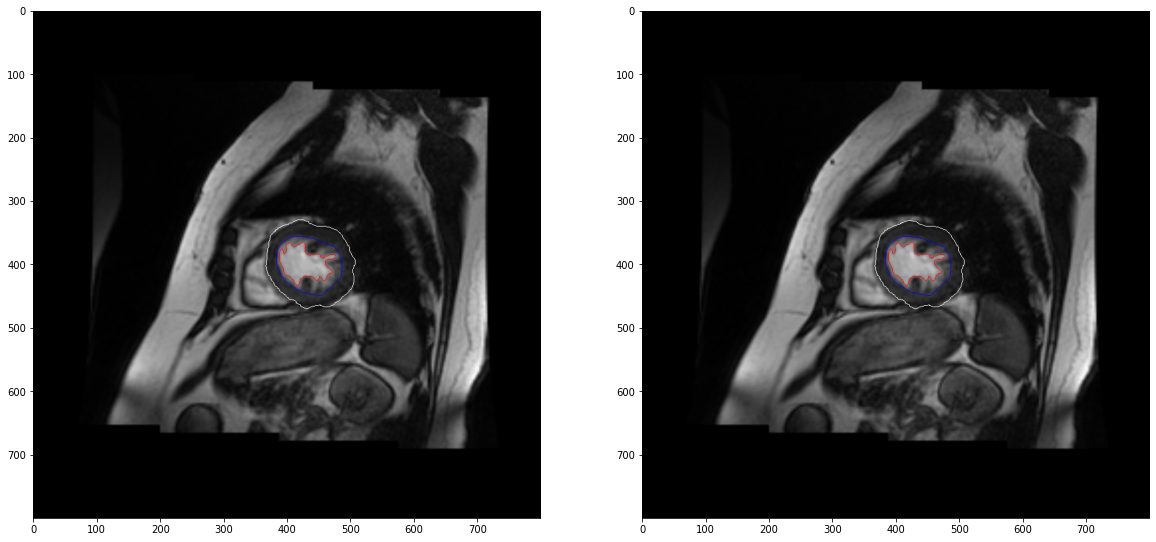

X15 4


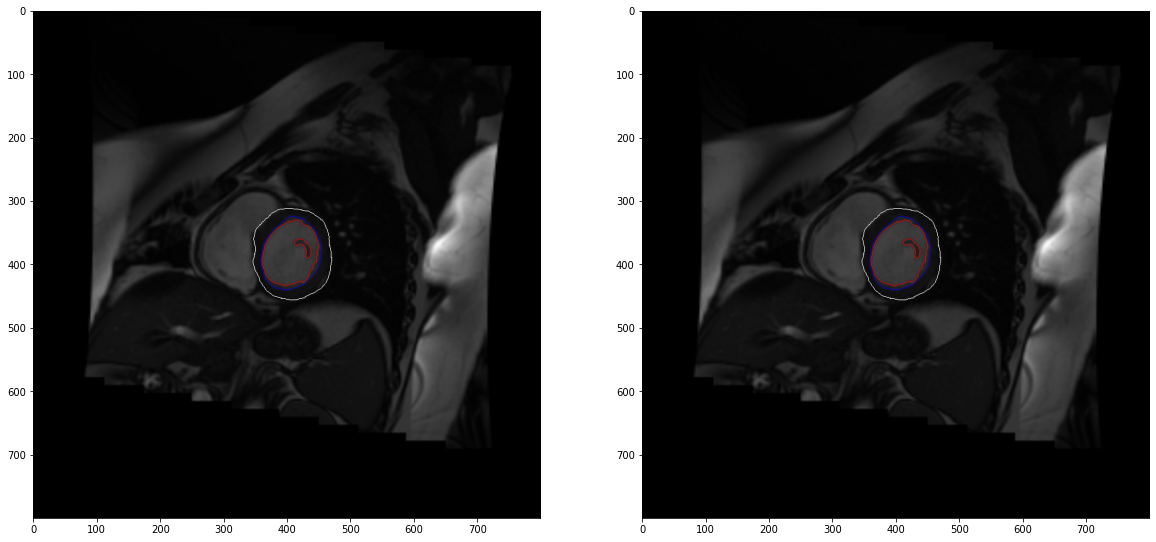

P165 2


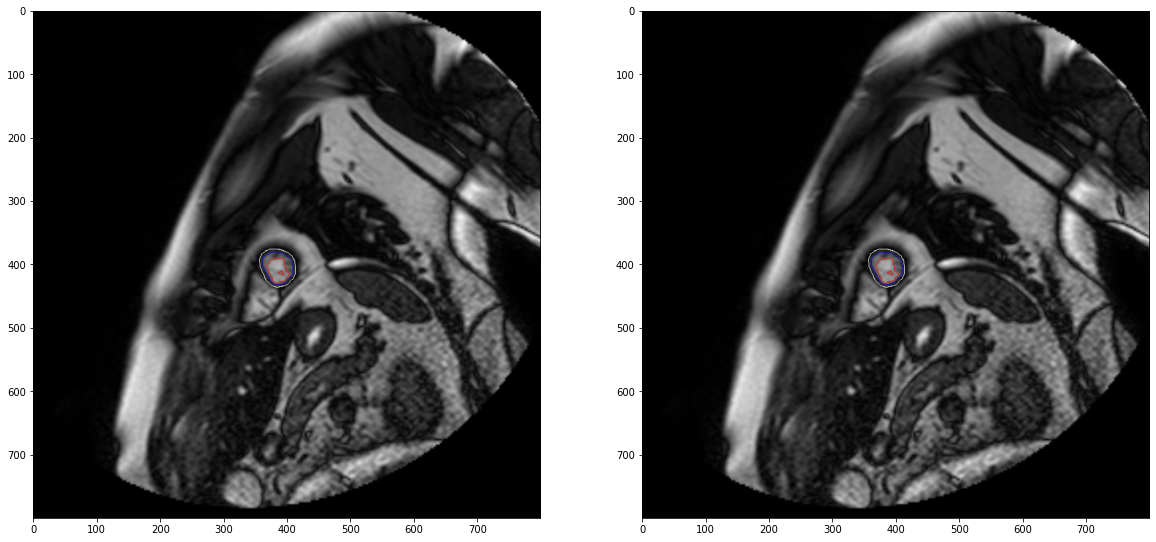

P91 1


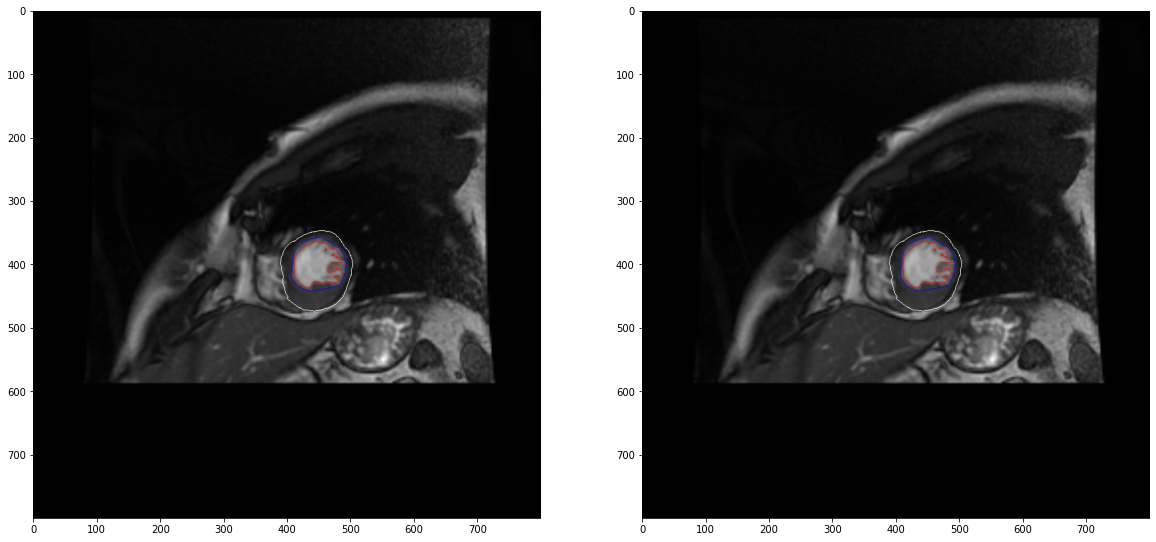

SBC 14


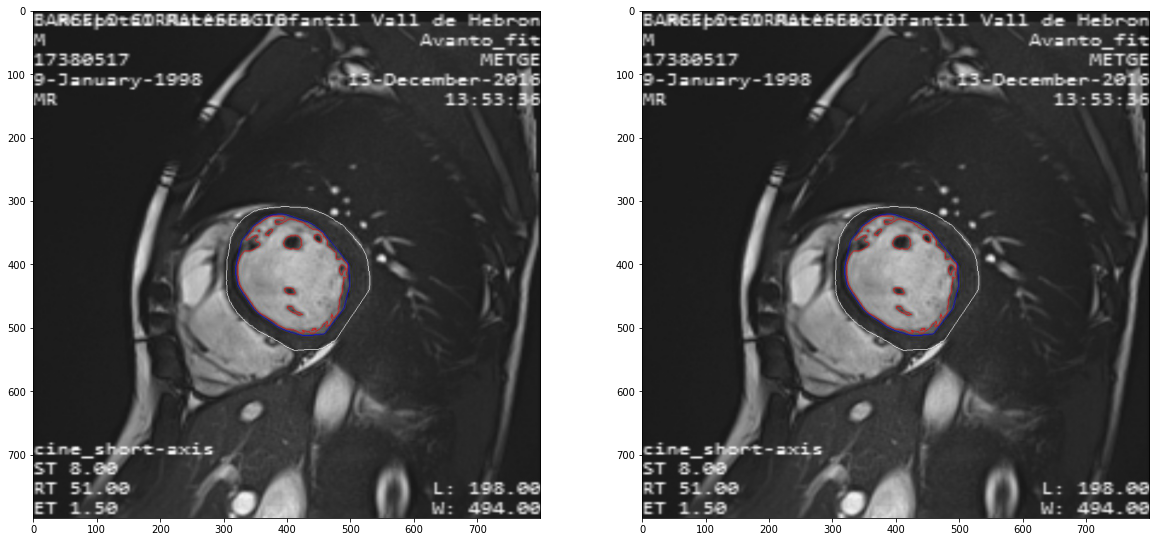

X31 4


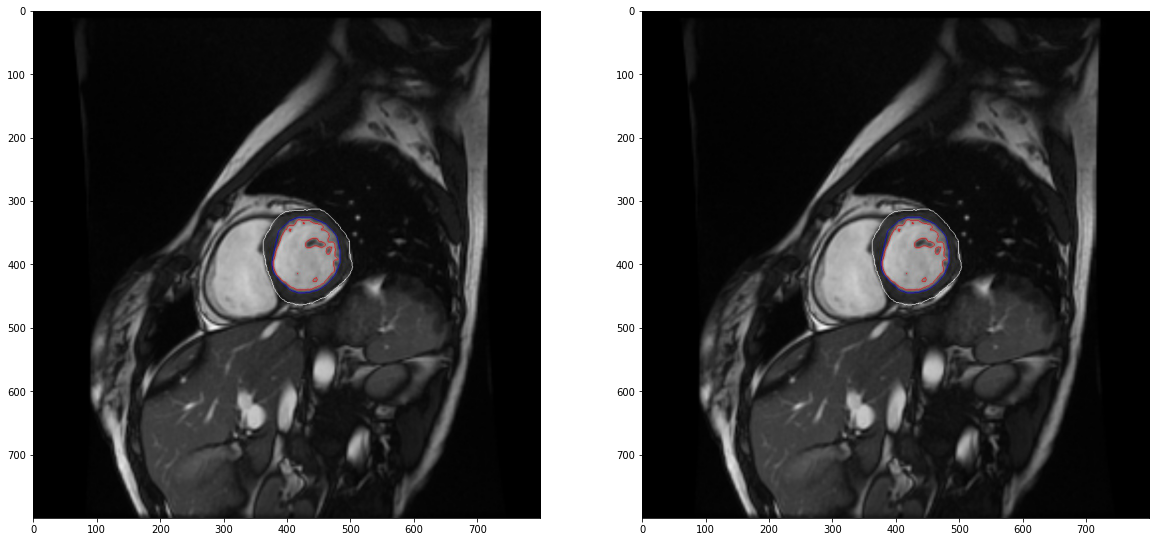

MHSML 8


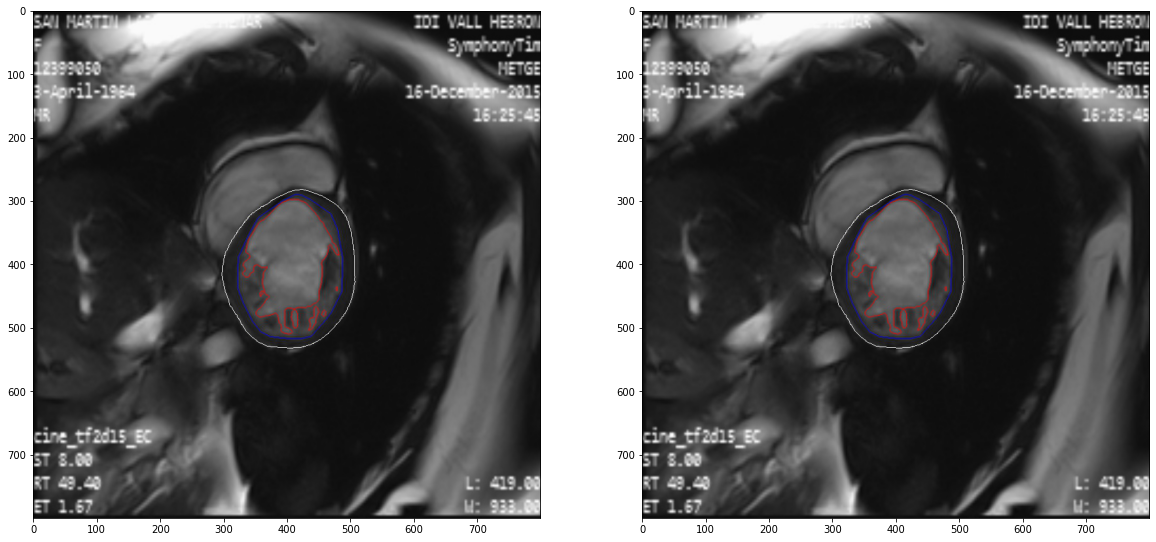

P8 3


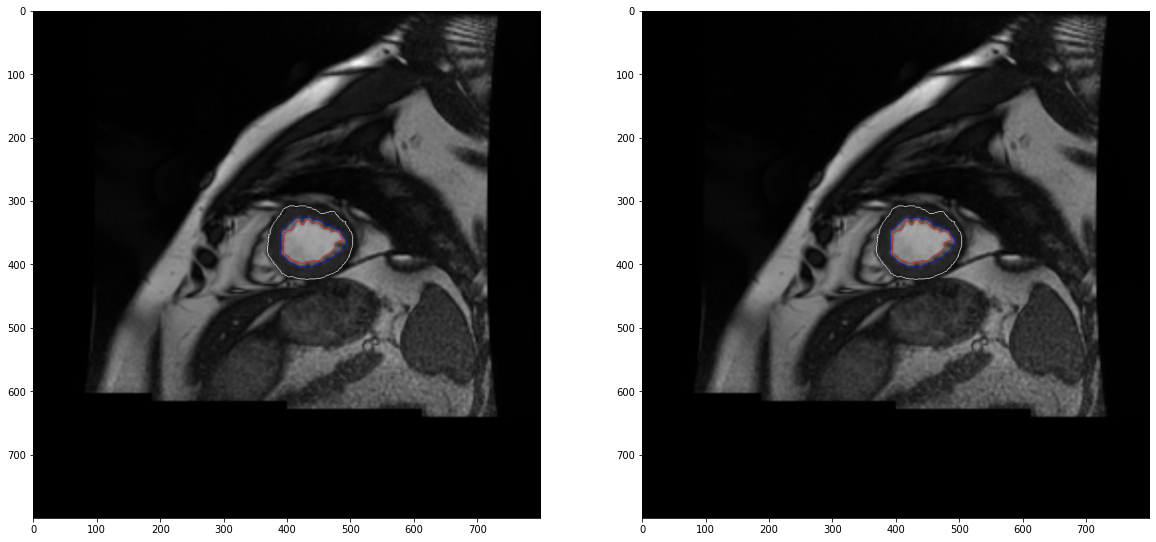

P162 8


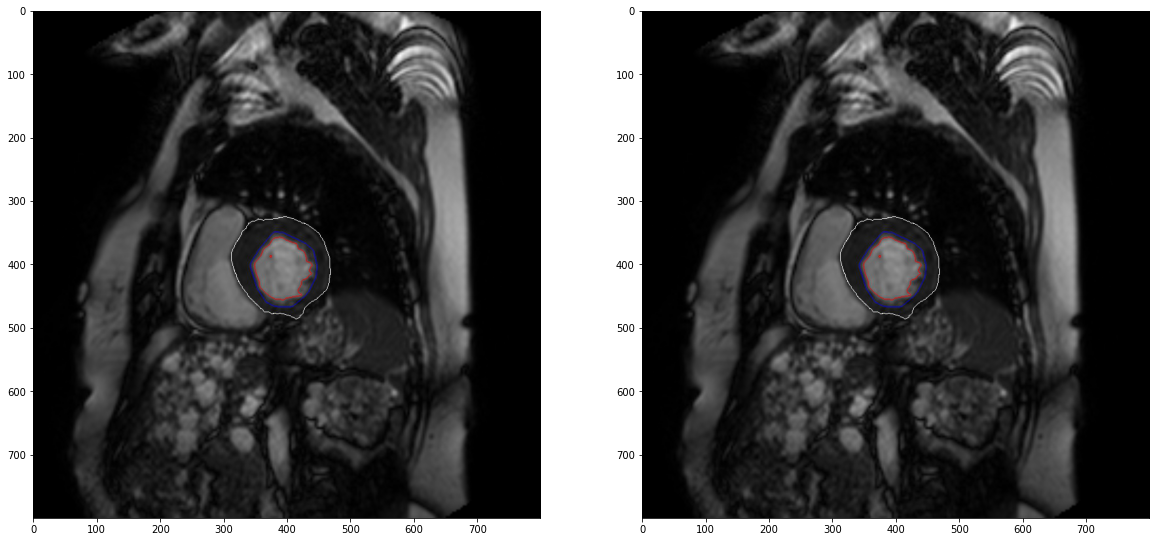

P111 6


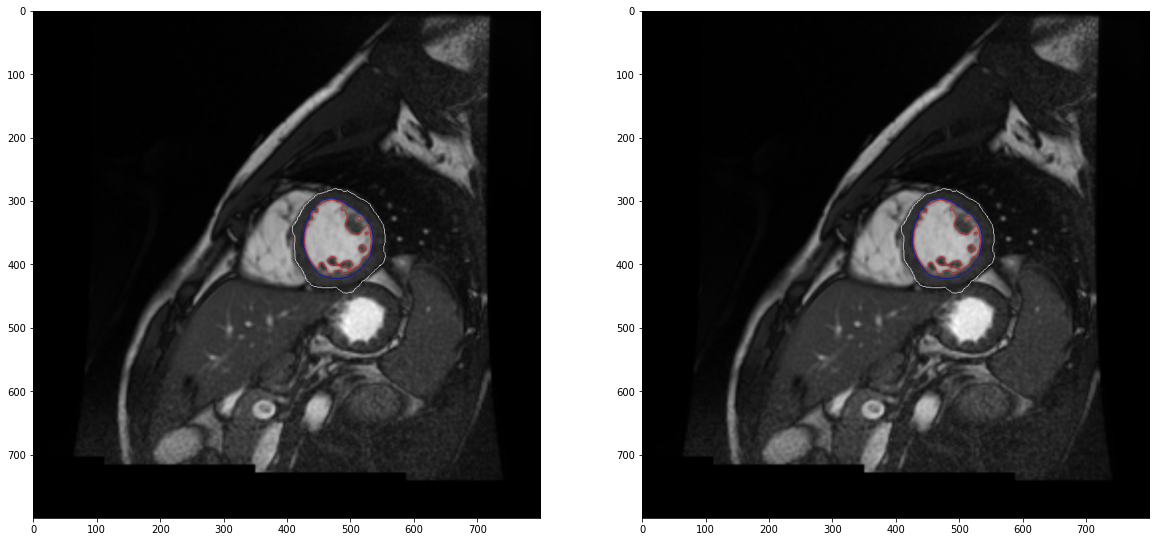

P291 4


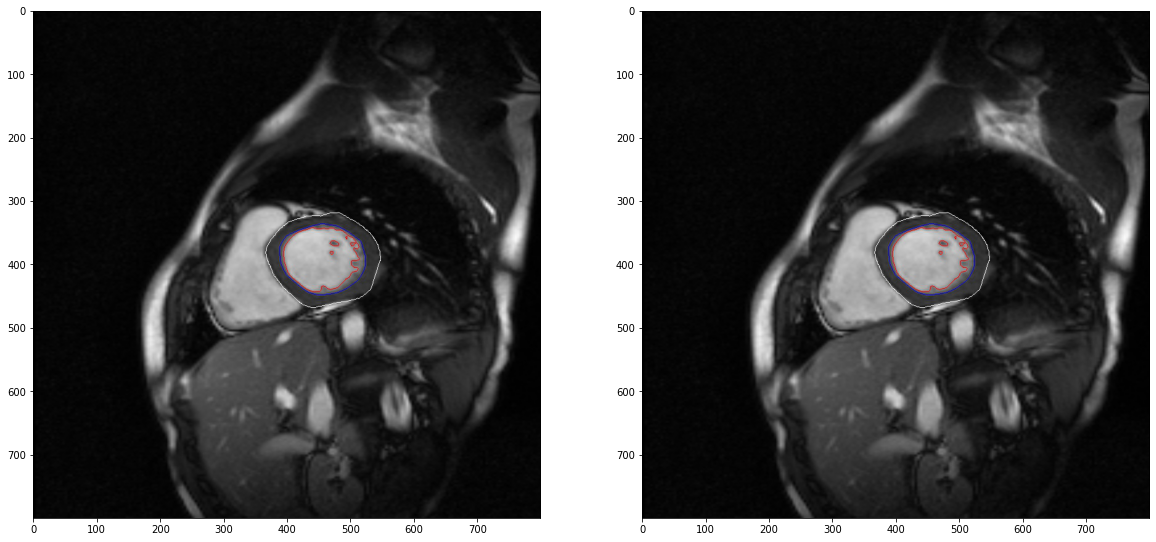

P162 6


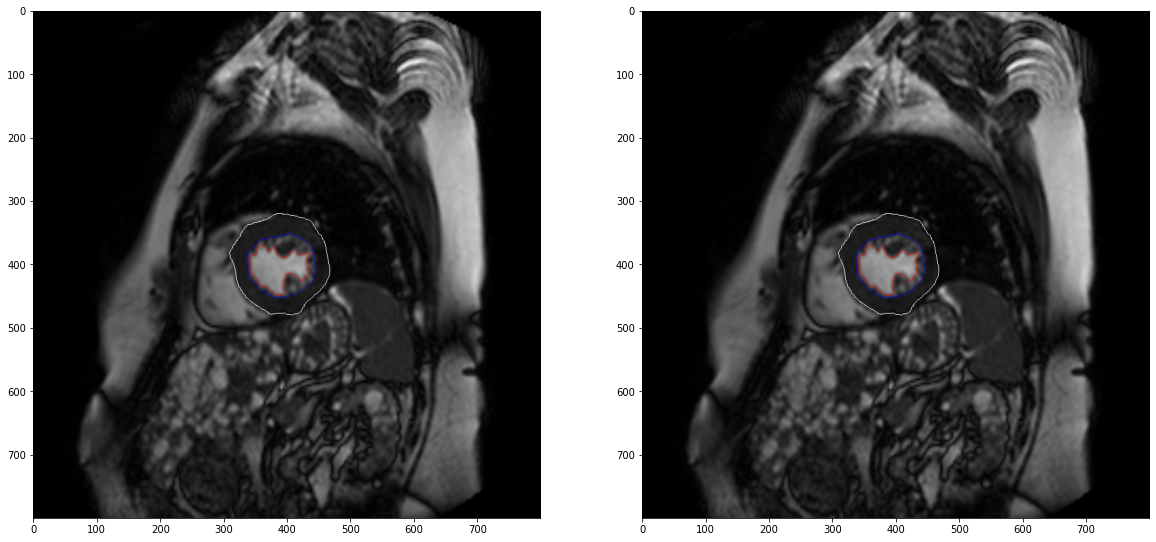

P38 4


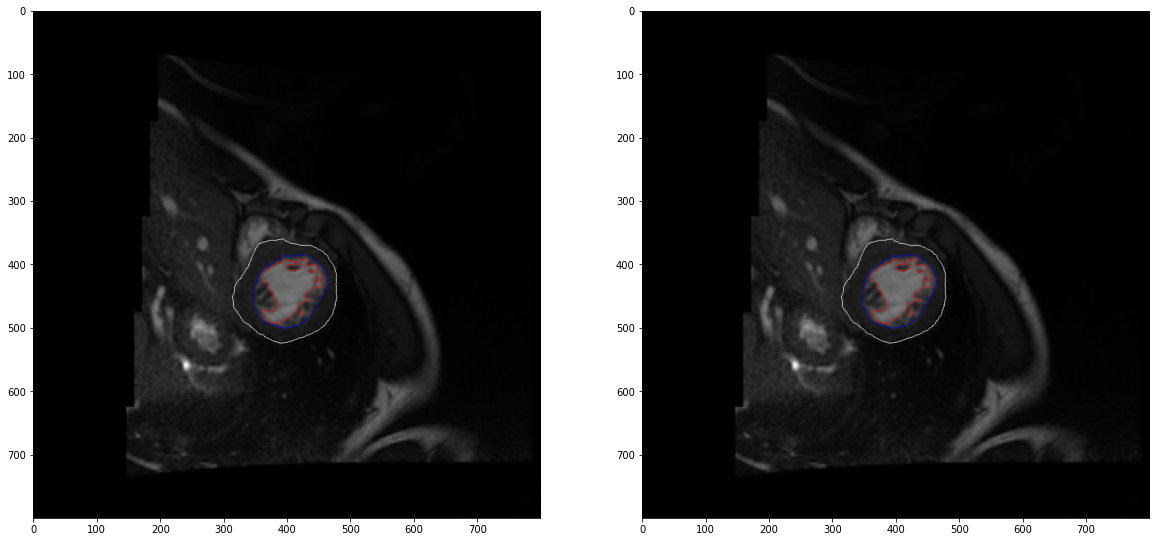

P123 1


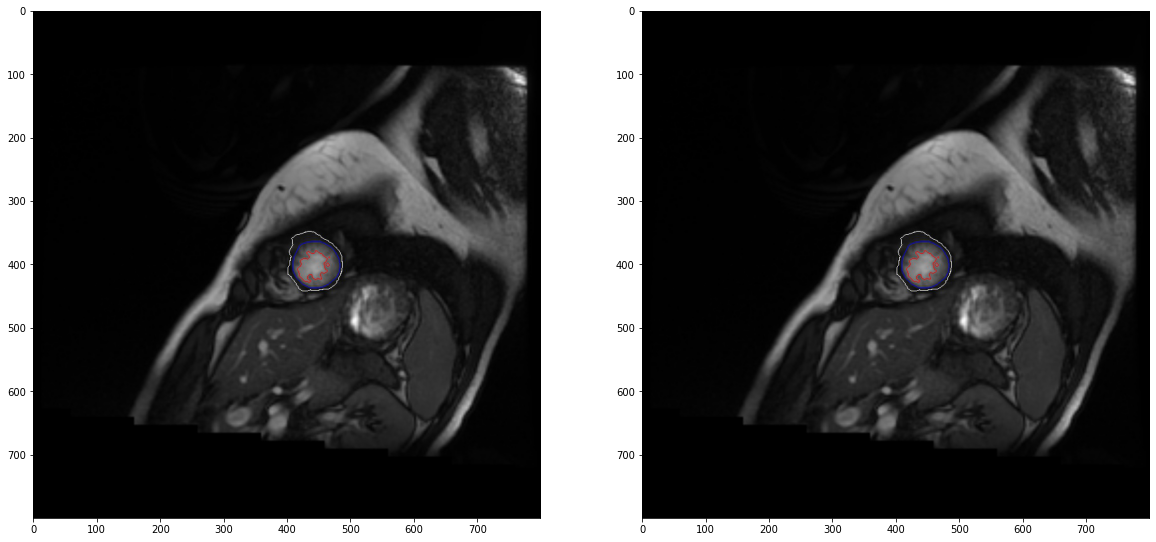

P199 6


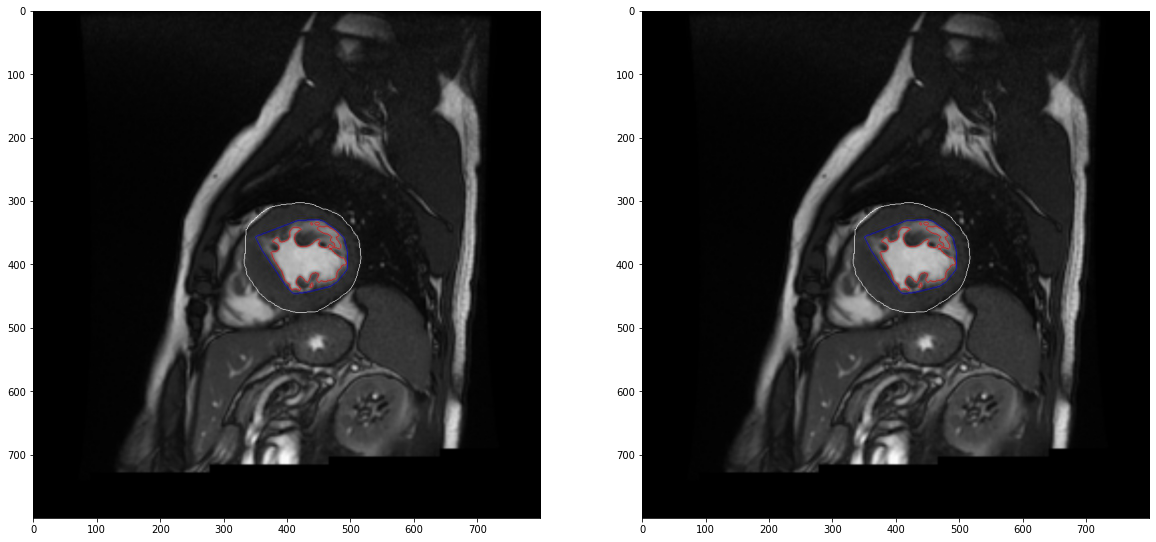

P281 4


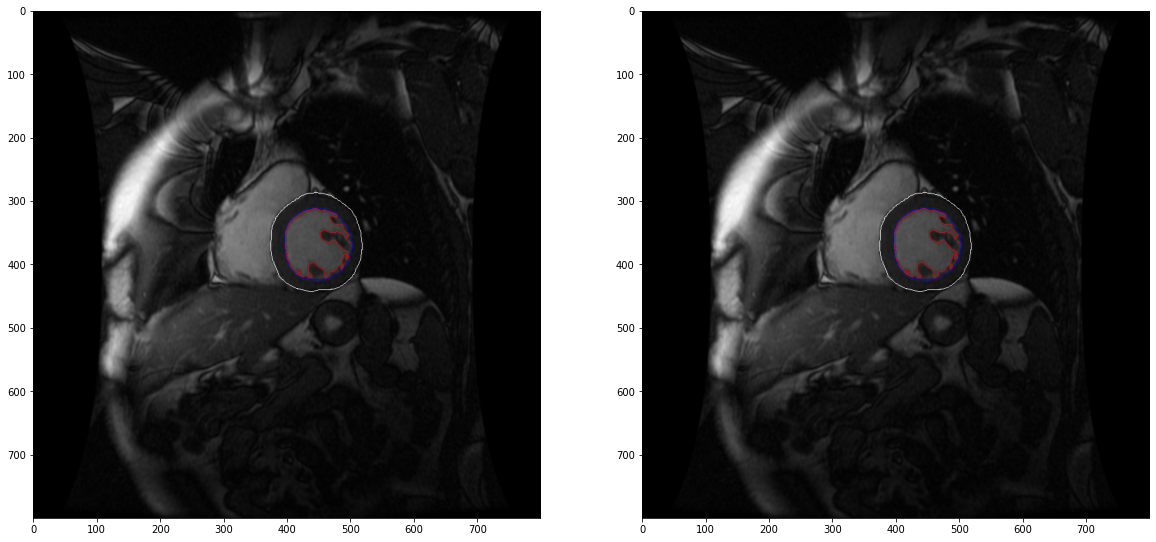

P254 3


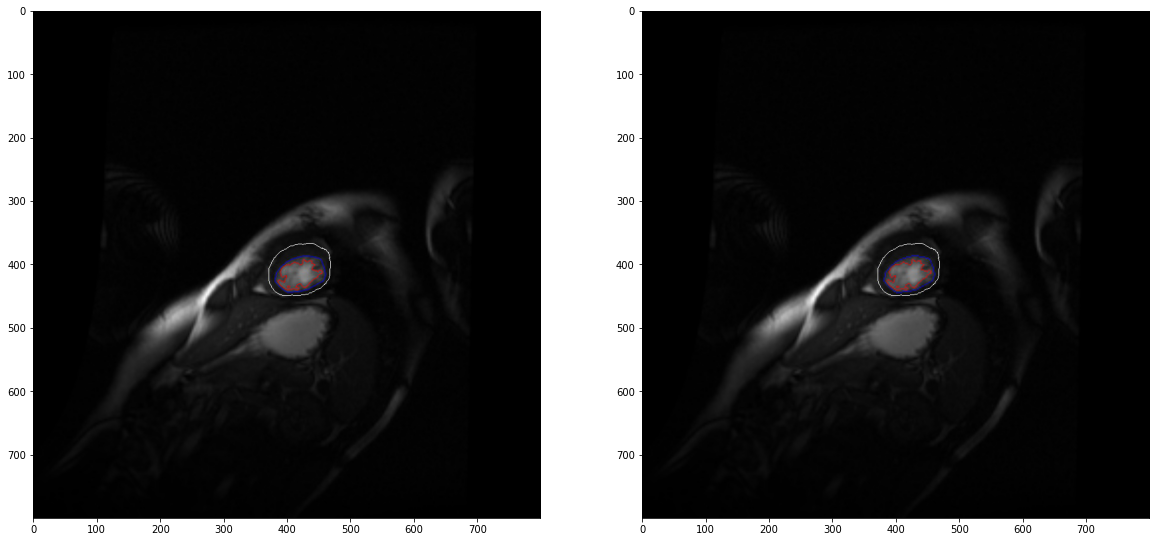

P226 10


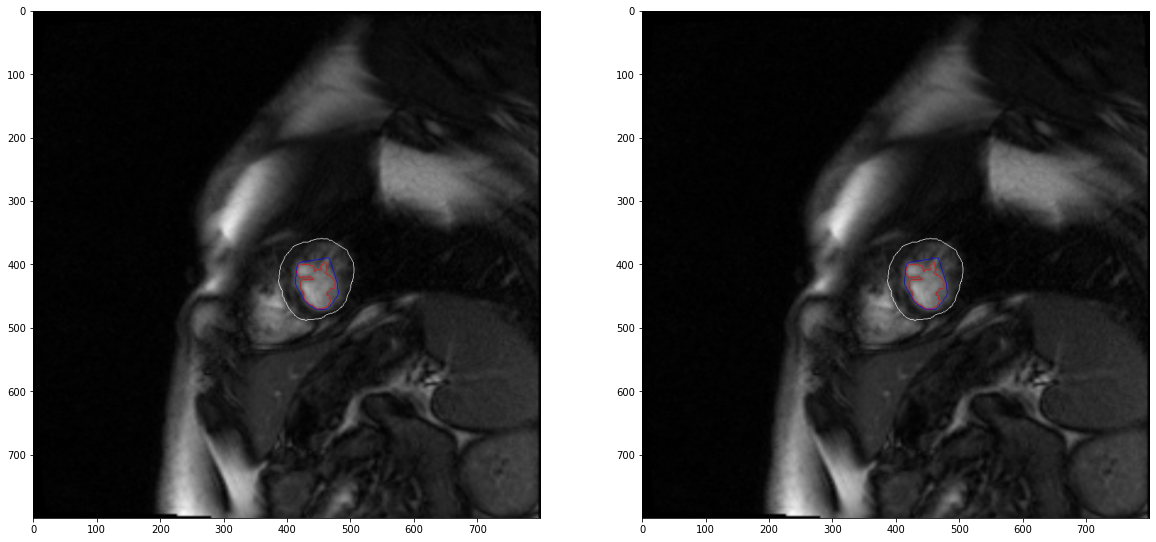

P132 4


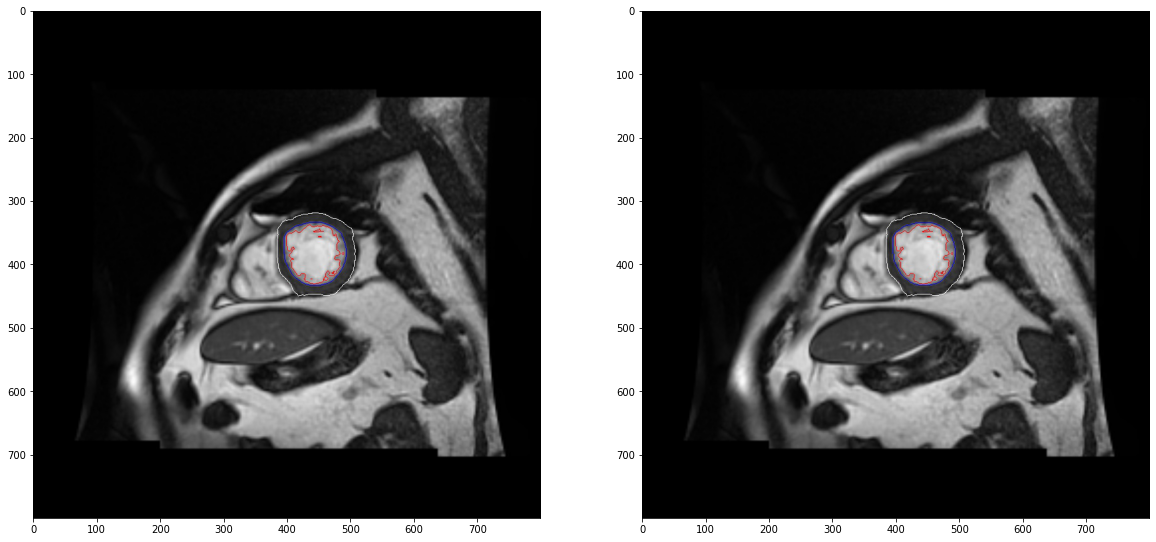

In [22]:
df_test = df_summary.sample(n=20)
plt.rcParams['figure.figsize'] = [10, 5]
for i, row in df_test.iterrows():
    print(row["patient"], row["slice"])
    original = row["original_output"]
    best = row["best_output"]
    img1 = mpimg.imread(original)
    #plt.imshow(img1)
    plt.show()
    img2 = mpimg.imread(best)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    #plt.imshow(img2)
    plt.show()

## Moving everything to a different folder and creating a new dataframe

In [23]:
output_folder = "../../lvnc-dataset/FINAL_OUTPUT/"

In [24]:
n_rows = []

for i, row in df_summary.iterrows():
    output_jpg = row["best_output"]
    copy(output_jpg, output_folder)
    copy(output_jpg.replace("_output.jpg", ".jpg"), output_folder)
    copy(output_jpg.replace("_output.jpg", ".cont"), output_folder)
    copy(output_jpg.replace("_output.jpg", ".dcm"), output_folder)
    copy(output_jpg.replace("_output.jpg", "_params.txt"), output_folder)
    copy(output_jpg.replace("_output.jpg", "_results.txt"), output_folder)
    n_rows.append({
        "patient": row["patient"],
        "slice": row["slice"],
        "set": row["set"],
        "reversed": row["reversed"],
        "score": row["score"],
        "pta_qlvthc": row["pta_best_approach"],
    })

df_final_combined = pd.DataFrame(n_rows)

In [25]:
df_final_combined

,patient,slice,set,reversed,score,pta_qlvthc
0,ANH,4,Hebron,False,5.0,41.98
1,ANH,5,Hebron,False,5.0,42.02
2,ANH,6,Hebron,False,4.5,42.78
3,ANH,7,Hebron,False,4.5,38.60
4,ANH,8,Hebron,False,5.0,37.26
...,...,...,...,...,...,...
3077,X9,4,X,False,5.0,35.32
3078,X9,5,X,False,5.0,30.86
3079,X9,6,X,False,5.0,26.88
3080,X9,7,X,False,5.0,25.68


In [26]:
df_final_combined.to_pickle(os.path.join(output_folder, "df.pick"))